In [61]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
train = pd.read_csv('train_V2.csv')

In [63]:
test = pd.read_csv('test_V2.csv')

In [64]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [65]:
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [67]:
def rstr(df, pred=None):
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/obs) *100
    skewness = df.skew()
    kurtosis = df.kurt()
    print('Data shape: ', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis', 'corr']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis=1)
    else:
        corr = df.corr()[pred]
        str =pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis=1, sort=False)
        corr_col = 'corr ' + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis',  corr_col]
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [68]:
train["group_size"] = train.groupby(["matchId"])['Id'].transform('count')
train["killPlace"] = train["killPlace"]/train["group_size"]
train["distanceSum"] = 0.81*train['walkDistance'] + 0.34*train['rideDistance'] + 0.14*train['swimDistance']
train["item"] = 0.63*train['boosts'] + 0.42*train['heals']
train["killPlace"] = -1*train["killPlace"]
train["headshotRatio"] = train["headshotKills"]/train["kills"]
train["killStreakRatio"] = train["killStreaks"]/train["kills"]
train["headshotRatio"].fillna(0,inplace=True)
train["killStreakRatio"].fillna(0, inplace=True)
train["killSum"] = 0.41*train["kills"]+0.28*train["DBNOs"]+0.3*train["assists"]
train["distanceMean"] = train.groupby(["groupId"])['distanceSum'].transform(np.mean)
train["itemMean"] = train.groupby(["groupId"])["item"].transform(np.mean)
train["killMean"] = train.groupby(["groupId"])["killSum"].transform(np.mean)
train["killPlaceMean"] = train.groupby(["groupId"])["killPlace"].transform(np.mean)
train["killPlaceMean"].fillna(0, inplace=True)
train["damageDealtMean"] = train.groupby(["groupId"])["damageDealt"].transform(np.mean)
train["damageDealtMean"].fillna(0,inplace=True)
train["revivesMean"] = train.groupby(["groupId"])["revives"].transform(np.mean)
train["meanWeapon"] = train.groupby(["groupId"])["weaponsAcquired"].transform(np.mean)
etc = train[['numGroups', 'Id', 'groupId','matchId', 'matchType']]
train.drop(['vehicleDestroys','numGroups', 'Id', 'groupId','matchId', 'matchType','rankPoints','killPoints','winPoints','matchDuration',
           'roadKills','teamKills','maxPlace','item','kills','assists','DBNOs','killSum','killStreaks','headshotKills',
           'group_size','walkDistance', 'rideDistance','swimDistance','boosts', 'heals','damageDealt','killPlace','revives','distanceSum','weaponsAcquired'], axis=1, inplace=True)

In [69]:
pd.set_option('display.max_rows', None)
details = rstr(train, 'winPlacePerc')
display(details.sort_values(by='corr winPlacePerc', ascending=False))

Data shape:  (4446966, 11)
___________________________
Data types:
 float64    11
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing ration,uniques,skewness,kurtosis,corr winPlacePerc
winPlacePerc,float64,4446965,3001,1,0.000022,"[[0.4444, 0.64, 0.7755, 0.1667, 0.1875, 0.037,...",0.098830,-1.245390,1.000000
killPlaceMean,float64,4446966,44582,0,0.000000,"[[-0.4921875, -0.4065934065934066, -0.33163265...",-0.096498,-0.920638,0.833877
distanceMean,float64,4446966,961979,0,0.000000,"[[148.2219, 2620.4942825000003, 576.5920000000...",1.097937,0.723630,0.805814
itemMean,float64,4446966,2252,0,0.000000,"[[0.0, 2.31, 1.365, 0.063, 0.77, 0.798, 0.1399...",1.982846,5.654877,0.682880
meanWeapon,float64,4446966,1208,0,0.000000,"[[1.25, 6.0, 2.0, 3.0, 1.0, 2.3333333333333335...",2.299382,38.695307,0.675383
damageDealtMean,float64,4446966,293186,0,0.000000,"[[102.1875, 142.8175, 107.3, 32.9, 100.0, 46.9...",2.880416,22.261450,0.549442
killMean,float64,4446966,12789,0,0.000000,"[[0.55, 0.7, 0.7000000000000001, 0.0, 0.41, 0....",2.785360,18.495186,0.531901
longestKill,float64,4446966,28284,0,0.000000,"[[0.0, 58.53, 18.44, 49.83, 37.91, 9.158, 36.0...",3.944918,24.295268,0.410154
revivesMean,float64,4446966,167,0,0.000000,"[[0.0, 0.3333333333333333, 0.2, 0.666666666666...",3.765025,90.086014,0.360267
killStreakRatio,float64,4446966,168,0,0.000000,"[[0.0, 1.0, 0.25, 0.5, 0.2222222222222222, 0.6...",0.746292,-1.189130,0.235207


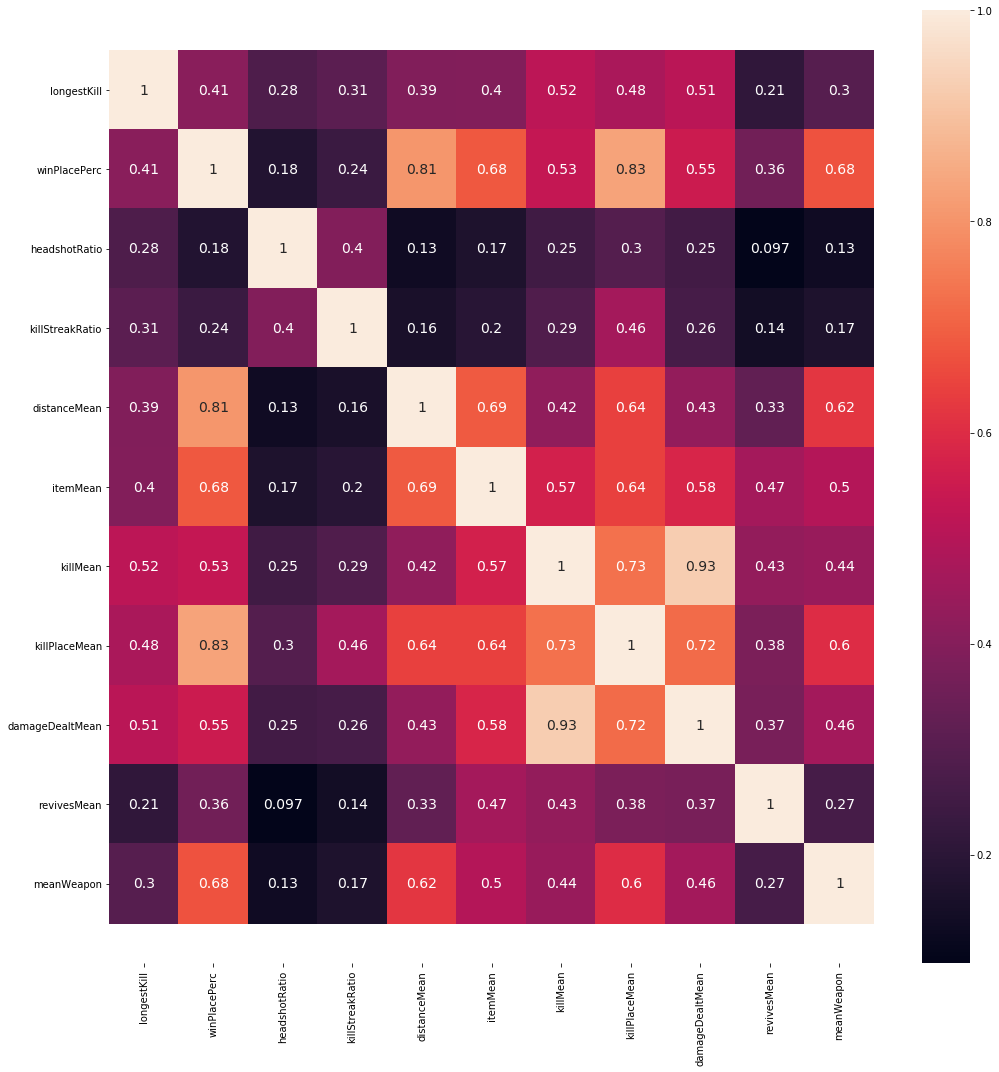

In [70]:
plt.figure(figsize=(15,15))
hm = sns.heatmap(train.corr(), annot=True, annot_kws={'size':14})
bottom, top = hm.get_ylim()
hm.set_ylim(bottom+0.5, top-0.5)
plt.tight_layout()
plt.show()

In [71]:
target = train['winPlacePerc']
target = target.fillna(target.mean())
train.drop('winPlacePerc', axis=1, inplace=True)

In [72]:
train.isnull().sum()

longestKill        0
headshotRatio      0
killStreakRatio    0
distanceMean       0
itemMean           0
killMean           0
killPlaceMean      0
damageDealtMean    0
revivesMean        0
meanWeapon         0
dtype: int64

In [73]:
x_train, x_test, y_train, y_test = train_test_split(train, target, train_size = 0.7, test_size = 0.3, random_state = 25)

In [74]:
lr = LinearRegression()
ridge = Ridge(alpha = 0.5)
lasso = Lasso(alpha = 0.5)
elanet = ElasticNet(alpha = 0.5, l1_ratio = 0.5)
Xgb = XGBRegressor(max_depth=10, n_jobs=-1, n_estimators=1000,tree_method='gpu_hist', gpu_id=0)
cat = CatBoostRegressor(max_depth=10, n_estimators=1000,task_type="GPU", verbose=False)

In [75]:
lr_model = lr.fit(x_train, y_train)
ridge_model = ridge.fit(x_train, y_train)
lasso_model = lasso.fit(x_train, y_train)
elanet_model = elanet.fit(x_train, y_train)
xgb_model = Xgb.fit(x_train, y_train)
cat_model = cat.fit(x_train, y_train)

[03:44:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [76]:
print("훈련 스코어(lr)     : %.4f" % lr_model.score(x_train, y_train))
print("훈련 스코어(ridge)  : %.4f" % ridge_model.score(x_train, y_train))
print("훈련 스코어(lasso)  : %.4f" % lasso_model.score(x_train, y_train))
print("훈련 스코어(elanet) : %.4f" % elanet_model.score(x_train, y_train))
print("훈련 스코어(xgb)    : %.4f" % xgb_model.score(x_train, y_train))
print("훈련 스코어(cat)    : %.4f" % cat_model.score(x_train, y_train))

훈련 스코어(lr)     : 0.8494
훈련 스코어(ridge)  : 0.8494
훈련 스코어(lasso)  : 0.6994
훈련 스코어(elanet) : 0.6995
훈련 스코어(xgb)    : 0.9541
훈련 스코어(cat)    : 0.9393


In [77]:
print("예측 스코어(lr)     : %.4f" % r2_score(y_test, lr_model.predict(x_test))) 
print("예측 스코어(ridge)  : %.4f" % r2_score(y_test, ridge_model.predict(x_test)))
print("예측 스코어(lasso)  : %.4f" % r2_score(y_test, lasso_model.predict(x_test))) 
print("예측 스코어(elanet) : %.4f" % r2_score(y_test, elanet_model.predict(x_test))) 
print("예측 스코어(xgb)    : %.4f" % r2_score(y_test, xgb_model.predict(x_test)))
print("예측 스코어(cat)    : %.4f" % r2_score(y_test, cat_model.predict(x_test)))

예측 스코어(lr)     : 0.8497
예측 스코어(ridge)  : 0.8497
예측 스코어(lasso)  : 0.6989
예측 스코어(elanet) : 0.6991
예측 스코어(xgb)    : 0.9440
예측 스코어(cat)    : 0.9359


In [78]:
print("예측 mae(lr)     : %.4f" % mean_absolute_error(y_test, lr_model.predict(x_test))) 
print("예측 mae(ridge)  : %.4f" % mean_absolute_error(y_test, ridge_model.predict(x_test))) 
print("예측 mae(lasso)  : %.4f" % mean_absolute_error(y_test, lasso_model.predict(x_test))) 
print("예측 mae(elanet) : %.4f" % mean_absolute_error(y_test, elanet_model.predict(x_test)))
print("예측 mae(xgb)    : %.4f" % mean_absolute_error(y_test, xgb_model.predict(x_test)))
print("예측 mae(cat)    : %.4f" % mean_absolute_error(y_test, cat_model.predict(x_test)))

예측 mae(lr)     : 0.0923
예측 mae(ridge)  : 0.0923
예측 mae(lasso)  : 0.1381
예측 mae(elanet) : 0.1380
예측 mae(xgb)    : 0.0528
예측 mae(cat)    : 0.0567
